In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
import matplotlib.pyplot as plt

In [8]:
import numpy as np

In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Loading Data

In [25]:
y = torch.load("Objects/labels.pt")
X = torch.load("Objects/glove_embeddings.pt")

In [26]:
X = pad_sequence(X.to_numpy(), batch_first=True)

In [27]:
class Data(Dataset):
    def __init__(self):
        self.x = X
        self.y = y
        
        self.n_samples = len(y)
        
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def __len__(self):
        return self.n_samples

In [28]:
data = Data()

In [29]:
train_data, test_data = random_split(data, [4400, 446])

In [30]:
batch_size = 5

In [31]:
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

# Helper Functions

In [32]:
# Gets the lengths of all of the sequences in a batch
def get_lengths(features):
    num_pads = 0
    length_list = []
    for i in features:
        for j in range(88):
            if torch.sum(i[j] == 0).item() == 300:
                num_pads += 1
        length = 88 - num_pads
        length_list.append(length)
        num_pads = 0
    return length_list


In [33]:
# convert output matrix into categories
# i.e [0.1, 3, -0.1] ----> 'Neutral'

def get_category(output_matrix):
  
    outputs = []
    
    cat_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
    
    for i in output_matrix:
        val = torch.argmax(i).item()
        outputs.append(cat_map[val])
    
    return outputs

# Define Architechture

In [92]:
# Typical RNN Model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.linear1 = nn.Linear(hidden_size, output_size)
        
    def forward(self, input_tensor):
        h0 = torch.zeros(self.num_layers, 10, self.hidden_size)
        
        output, h_n = self.rnn(input_tensor, h0)
        
        output = pad_packed_sequence(output, batch_first=True)
        
        # length of sequences
        indices = output[1] - 1 
        
        # update batch size (if its the last batch, the size will be different)
        current_batch_size = output[0].size()[0]
        
        output = output[0][range(current_batch_size), indices, :]
        
        output = self.linear1(output)
        
        return output

In [54]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRU, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.linear1 = nn.Linear(hidden_size, output_size)
        
    def forward(self, input_tensor):
        h0 = torch.zeros(self.num_layers, 10, self.hidden_size)
        
        output, h_n = self.rnn(input_tensor, h0)
        
        output = pad_packed_sequence(output, batch_first=True)
        
        # length of sequences
        indices = output[1] - 1 
        
        # update batch size (if its the last batch, the size will be different)
        current_batch_size = output[0].size()[0]
        
        output = output[0][range(current_batch_size), indices, :]
        
        output = self.linear1(output.view(current_batch_size,64))
        
        return output

In [98]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear1 = nn.Linear(hidden_size, output_size)
        
    def forward(self, input_tensor):
        
        h0 = torch.zeros(self.num_layers, 10, self.hidden_size)
        c0 = torch.zeros(self.num_layers, 10, self.hidden_size)
        output, (h_n, c_n) = self.rnn(input_tensor, (h0, c0))
        
        
        output = pad_packed_sequence(output, batch_first=True)
        
        # length of sequences
        indices = output[1] - 1 
        
        # update batch size (if its the last batch, the size will be different)
        current_batch_size = output[0].size()[0]
        
        output = output[0][range(current_batch_size), indices, :]
        
        output = self.linear1(output.view(current_batch_size,64))
        
        return output

## hyperparameters

In [86]:
num_epochs = 10
hidden_size = 64
output_size = 3
input_size = 300
num_layers = 1

## Example Forward pass

In [87]:
example_rnn = RNN(input_size, hidden_size, num_layers, output_size)

In [88]:
example_data = iter(train_loader).next()

In [89]:
print(f'Shape of Data: {example_data[0].size()}')
print(f'Labels: {example_data[1]}')

# example_data is a padded sequence of glove word embeddings

# -> [0.1, -1, 2, -0.23, ... -0.12, 1.22, 0.01] 300 dimensional embeddings with 88 being the longest sequence
# -> [-0.1, 0, 1, -0.21, ... -0.1, 0, 0.1, 0.1]
# -> [0, 0, 0, 0, ... -0, 0, 0] # seequences shorter than 88 have a padding value of 0

Shape of Data: torch.Size([5, 88, 300])
Labels: tensor([1, 1, 1, 1, 2])


In [90]:
# first we need to pack the sequence using pytorch's packed sequence

# 1.) get feature lengths
feature_lengths = get_lengths(example_data[0])
                                    
# 2.) pack the sequence; Parameters --> batch_first: ensures the batch size is first dimension, enforse_sorted: allows for unsorted sequence
packed = pack_padded_sequence(example_data[0], feature_lengths, batch_first = True, enforce_sorted=False)

this creates a pytorch [PackedSequence]("https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.PackedSequence.html#torch.nn.utils.rnn.PackedSequence") object, and you can click the link to the documentation. All pytorch recurrent layers accept this data type as an input. This is very useful because we can pass sequences of variable length into our network and we can train on the orginal sequence instead of a padded sequence. Here we will pass a sample batch from our training data as a packed sequence through an RNN network. 

In [93]:
output = example_rnn(packed.float())
print(output)

tensor([[ 3.4250e-01,  1.2086e-01,  2.0981e-01, -9.7839e-02, -8.1826e-01,
         -7.6284e-02,  7.7917e-01, -7.1370e-01, -2.9931e-02,  9.8397e-02,
         -6.7217e-01,  9.7613e-02, -1.7813e-01,  7.1389e-01,  7.8130e-01,
          2.3248e-01,  3.6372e-01, -8.3909e-03,  4.2826e-01, -6.0969e-01,
          4.3287e-01, -4.6750e-01,  3.5054e-01,  3.1022e-02,  4.8378e-01,
          6.5342e-02,  3.0154e-01,  1.8664e-02,  6.1125e-01, -5.9462e-01,
         -1.6414e-01,  4.8485e-01, -7.4002e-01, -1.9750e-01,  7.1268e-02,
          1.0213e-01,  2.9473e-01,  4.7267e-01,  3.9441e-01,  3.7787e-01,
          3.1589e-01, -2.6609e-01, -1.1995e-01,  1.0029e-01,  6.8082e-01,
         -1.9115e-01, -8.4104e-02,  4.5412e-01, -4.1435e-01,  3.0284e-01,
          1.0518e-01,  1.0963e-02, -2.1144e-01,  4.1045e-01,  1.3906e-01,
         -2.7106e-01,  5.8126e-01,  2.2131e-01,  1.0419e-01,  2.4421e-01,
          5.2437e-01,  1.8421e-01,  4.9146e-01,  3.4458e-01],
        [ 6.1660e-01,  4.4456e-01,  8.0630e-01, -9

In [62]:
# get predictions as category
get_category(output)

['negative', 'neutral', 'negative', 'negative', 'neutral']

In [63]:
# actual values
example_data[1]

tensor([2, 1, 2, 2, 1])

# Training

In [94]:
learning_rate = 0.001

In [99]:
rnn = LSTM(input_size, hidden_size, num_layers, output_size)
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [100]:
# Training loop
n_total_steps = np.ceil(len(train_data) / batch_size)
all_losses = []
loss_step = 25
current_loss = 0

for epoch in range(num_epochs):
    for i, (feature, label) in enumerate(train_loader):
        
        # pack seequence
        sequence_lengths = get_lengths(feature)
        
        packed = pack_padded_sequence(feature, sequence_lengths, batch_first=True, enforce_sorted=False)
       
        # forward pass
        output = rnn(packed.float())
        
        #backward pass
        loss = criterion(output, label)
        loss.backward()
        current_loss += loss
        
        #update weights
        optimizer.step()
        optimizer.zero_grad()
        
        # Store Average Losses for plotting
        if (i+1) % loss_step == 0:
            avg_loss = current_loss / loss_step
            all_losses.append(avg_loss)
            current_loss = 0

        #log results
        if (i+1) % 100 == 0:
            print(f'Epoch: {epoch} --- Step:{i+1} / {n_total_steps} --- Loss: {all_losses[-1]}') 
            pass
        

Epoch: 0 --- Step:100 / 880.0 --- Loss: 0.7353146076202393
Epoch: 0 --- Step:200 / 880.0 --- Loss: 0.8452717661857605
Epoch: 0 --- Step:300 / 880.0 --- Loss: 0.7754443287849426
Epoch: 0 --- Step:400 / 880.0 --- Loss: 0.8266008496284485
Epoch: 0 --- Step:500 / 880.0 --- Loss: 0.7447283267974854
Epoch: 0 --- Step:600 / 880.0 --- Loss: 0.8402159214019775
Epoch: 0 --- Step:700 / 880.0 --- Loss: 0.760612964630127
Epoch: 0 --- Step:800 / 880.0 --- Loss: 0.7216203808784485
Epoch: 1 --- Step:100 / 880.0 --- Loss: 0.6923043727874756
Epoch: 1 --- Step:200 / 880.0 --- Loss: 0.6399832963943481
Epoch: 1 --- Step:300 / 880.0 --- Loss: 0.6120502352714539
Epoch: 1 --- Step:400 / 880.0 --- Loss: 0.6253939270973206
Epoch: 1 --- Step:500 / 880.0 --- Loss: 0.5372741222381592
Epoch: 1 --- Step:600 / 880.0 --- Loss: 0.6991738080978394
Epoch: 1 --- Step:700 / 880.0 --- Loss: 0.6174448132514954
Epoch: 1 --- Step:800 / 880.0 --- Loss: 0.6307486891746521
Epoch: 2 --- Step:100 / 880.0 --- Loss: 0.581733644008636

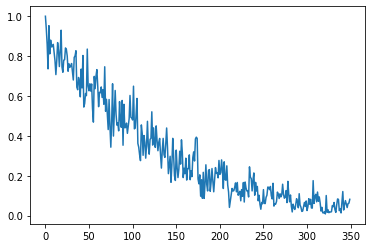

In [101]:
all_losses = [i.item() for i in all_losses]
plt.plot(all_losses)
plt.show()

# Model Evaluation

In [102]:
with torch.no_grad():
    predictions = []
    labels = []
    for (feature, label) in test_loader:
        
        #pack sequence
        sequence_lengths = get_lengths(feature)
        packed = pack_padded_sequence(feature, sequence_lengths, batch_first=True, enforce_sorted=False)
        
        # forward pass
        output = rnn(packed.float())
        
        for i in range(output.size()[0]):
            pred = torch.argmax(output[i]).item()
            predictions.append(pred)
            actual = label[i]
            labels.append(actual)

In [103]:
total_acc = accuracy_score(predictions, labels)

In [104]:
confusion_matrix(predictions, labels)

array([[ 48,   9,   5],
       [ 16, 223,  32],
       [  8,  23,  82]])

## Logging Model

In [105]:
total_acc

0.7914798206278026

In [106]:
rnn

LSTM(
  (rnn): LSTM(300, 64, batch_first=True)
  (linear1): Linear(in_features=64, out_features=3, bias=True)
)

In [107]:
log_entry = {
    'model': rnn,
    'features': 'glove embeddings',
    'model_type': 'LSTM',
    'acc': total_acc,
    'notes': 'LSTM baseline'
    
}

In [73]:
model_log = []

In [108]:
model_log.append(rnn)

In [109]:
model_log

[GRU(
   (rnn): GRU(300, 64, batch_first=True)
   (linear1): Linear(in_features=64, out_features=3, bias=True)
 ),
 LSTM(
   (rnn): LSTM(300, 64, batch_first=True)
   (linear1): Linear(in_features=64, out_features=3, bias=True)
 )]